# Clothes Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for image classification. We will use a new version of the famous MNIST dataset (the original is a dataset of handwritten digits). The version we are going to use is called Fashion MNIST (https://pravarmahajan.github.io/fashion/) and is a dataset of small images of clothes and accessories.



The dataset labels are the following:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## TODO: Insert your surname, name and ID number

Student surname: Lipani 

Student name: Samuele Pio   
    
ID: 2025168

In [1]:
#load the required packages

%matplotlib inline  

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import sklearn.metrics as skm

In [2]:
# helper function to load Fashion MNIST dataset
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz' % kind)
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)
    return images, labels

In [3]:
#fix your ID ("numero di matricola") and the seed for random generator (as usual you can try different seeds)
ID = 2025169# place a random seed
np.random.seed(ID)

In [4]:
#load the Fashion MNIST dataset from the 'data' folder and let's normalize the features so that each value is in [0,1] 

X, y = load_mnist('data', kind='train')
# rescale the data
X, y = X / 255., y # original pixel values are between 0 and 255
print(X.shape, y.shape)

(60000, 784) (60000,)


Now split into training and test. Make sure that each label is present at least 10 times
in training. If it is not, then keep adding permutations to the initial data until this 
happens.

In [5]:
# Random permute the data and split into training and test taking the first 600
# data samples as training and 4000 samples as test
permutation = np.random.permutation(X.shape[0])

X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

labels, freqs = np.unique(y_train, return_counts=True)
# già tramite il comando np.unique vengono misurate quali sono le diverse labels contenute in y_train (in qunato ci interessa che il training set sia rappresentativo della realtà) e quante volte si presentano
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)


Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [73 55 64 51 62 47 71 65 56 56]


In [6]:
#function for plotting a image and printing the corresponding label
def plot_input(X_matrix, labels, index):
    print("INPUT:")
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    print("LABEL: %i"%labels[index])
    return

INPUT:


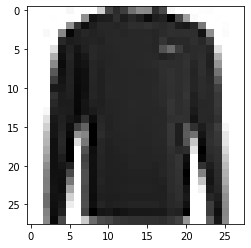

LABEL: 2
INPUT:


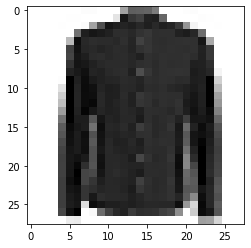

LABEL: 6
INPUT:


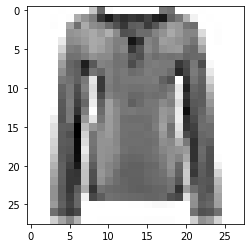

LABEL: 6
INPUT:


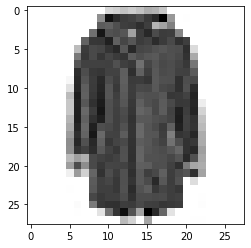

LABEL: 4


In [7]:
#let's try the plotting function
plot_input(X_train,y_train,5)
plot_input(X_test,y_test,50)
plot_input(X_test,y_test,500)
plot_input(X_test,y_test,700)

In [8]:
# potrei provare a rappresentare ad esempio due delle componenti dei vettori del training set e per ogni label diversa un colore differente. Un dato è costituito da 784 componenti e in totale nel training set ne abbiamo 600 dunque limito il numero di colonne alle prime due ad esempio:  
import random 
randomnum = random.randint(0,784)
xplot = X_train[:,randomnum:(randomnum+2)] # randomicamente scelgo due componenti tra le 784 di ogni vettore
yplot = y_train
dic = {}
for i in range(10):
    dic[i] = []
# in questo caso dobbiamo distinguere le label da 0 a 9 quindi potrei costruire un dataset in modo che ciascuna feature sia una label diversa. Creo un dizionario con chiavi il numero della classe a cui appartiene il singolo dato 
np.shape(xplot)
for sample, label  in zip(xplot[:],yplot[:]) : # dove sample sono array di dimensione due mentre label è un singolo numero  
    for i in range(10) :
        if label == i :
            dic[i].append(sample)
print('Il numero dei samples presi in esame è',np.sum([len(dic[i]) for i in dic.keys()]))
# più per una verifica che per una vera necessità di conteggio del numero di samples 


Il numero dei samples presi in esame è 600


Naturalmente è necessario considerare soltanto due componenti dei vettori di dimensione 784 e può capitare che alcune componenti siano zero in quanto rappresentano i bit che compongono le immagini con una scala di grigi ben precisa 

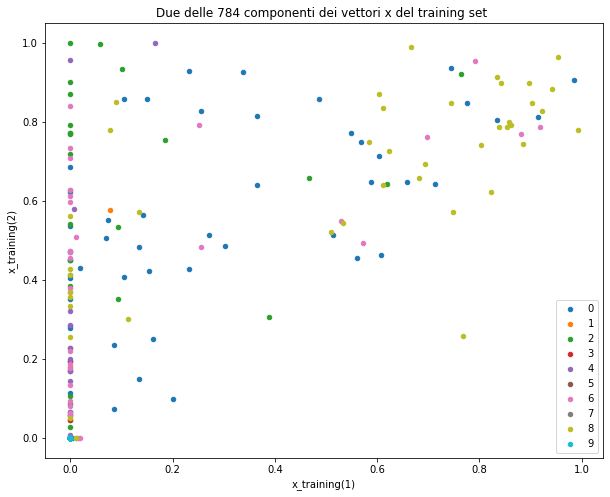

In [9]:
# Posso iterare sul range(10) e plottare con colori diversi le nove categorie in 2D. Creo dunque array di array che altro non sono matrici di n righe e due colonne (dove n sono gli array che hanno come label corrispondente la i-esima)
for i in range(10) :
    plt.scatter(np.array(dic[i])[:,0], np.array(dic[i])[:,1], label=i, s=20)
plt.xlabel('x_training(1)')
plt.ylabel('x_training(2)')
plt.title('Due delle 784 componenti dei vettori x del training set ')
plt.gcf().set_size_inches((10, 8)) 
plt.legend()

Tuttavia da una rappresentazione del genere, poichè in principio i vettori hanno 784 componenti e ne sto selezionando soltanto due da rappresentare, è difficile poter intuire un kernel adatto a classificare tali immagini. Infatti avremmo bisogno di una visione più globale, cioè sempre in più dimensioni per capire in che modo essi possano essere separati.

## TO DO 1
Use a SVM classifier with cross validation to pick a model. Use a 4-fold cross-validation. Let's start with a Linear kernel:

In [10]:
#import SVC
from sklearn.svm import SVC
#import for Cross-Validation
from sklearn.model_selection import GridSearchCV
gridlist = [] # sarà utile succcessivamente
# parameters for linear SVM
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), parameters, cv=4)
gridlist.append(grid)
grid.fit(X_train, y_train)

# definisco un dizionario contenente come chiavi il nome del kernel che stiamo utilizzando e come values invece l'errore minimo associato ad un hyperparameter o ad una combinazione di hyperparameters scelti dal gridsearch (l'errore è uguale a 1-score)

errors = {}
print ('RESULTS FOR LINEAR KERNEL')

print("Best parameters set found:\n", grid.best_params_)

print("Score with best parameters:\n", grid.best_score_)

print("All scores on the grid:\n", grid.cv_results_['mean_test_score'])

errors['linear'] = 1-grid.cv_results_['mean_test_score']

RESULTS FOR LINEAR KERNEL
Best parameters set found:
 {'C': 10}
Score with best parameters:
 0.75
All scores on the grid:
 [0.12166667 0.12166667 0.50166667 0.73       0.75       0.75      ]


## TO DO 2
Pick a model for the Polynomial kernel with degree=2:

In [11]:
# parameters for poly with degree 2 kernel
parameters1 = {'C': [0.05, 0.5, 5],'gamma':[0.05,0.5,5.]}

#run SVM with poly of degree 2 kernel

grid1 = GridSearchCV(SVC(kernel='poly', degree=2), parameters1, cv=4)
gridlist.append(grid1)
grid1.fit(X_train, y_train)

print ('RESULTS FOR POLY DEGREE=2 KERNEL')

print("Best parameters set found:\n", grid1.best_params_)

print("Score with best parameters:\n", grid1.best_score_)

print("All scores on the grid:\n", grid1.cv_results_['mean_test_score'])
# mi restituisce tutte le varie combinazioni a coppie di C e gamma. Infatti abbiamo 9 scores diversi per le diverse coppie 
errors['poly2'] = 1-grid1.cv_results_['mean_test_score']

RESULTS FOR POLY DEGREE=2 KERNEL
Best parameters set found:
 {'C': 0.5, 'gamma': 0.05}
Score with best parameters:
 0.7433333333333334
All scores on the grid:
 [0.70333333 0.73166667 0.73166667 0.74333333 0.73166667 0.73166667
 0.73166667 0.73166667 0.73166667]


## TO DO 3

Now let's try a higher degree for the polynomial kernel (e.g., 4th degree).

In [12]:
# parameters for poly with higher degree kernel
parameters2 = {'C': [0.05, 0.5, 5],'gamma':[0.05,0.5,5.]}

#run SVM with poly of higher degree kernel
degree = 4

grid2 = GridSearchCV(SVC(kernel='poly', degree=4), parameters1, cv=4)
gridlist.append(grid2)
grid2.fit(X_train, y_train)

print ('RESULTS FOR POLY DEGREE=', degree, ' KERNEL')

print("Best parameters set found:\n", grid2.best_params_)

print("Score with best parameters:\n", grid2.best_score_)

print("All scores on the grid:\n", grid2.cv_results_['mean_test_score'])

errors['poly4'] = 1-grid2.cv_results_['mean_test_score']

RESULTS FOR POLY DEGREE= 4  KERNEL
Best parameters set found:
 {'C': 0.5, 'gamma': 0.05}
Score with best parameters:
 0.7133333333333334
All scores on the grid:
 [0.69833333 0.68333333 0.68333333 0.71333333 0.68333333 0.68333333
 0.68333333 0.68333333 0.68333333]


## TO DO 4
Pick a model for the Radial Basis Function kernel:

In [13]:
# parameters for rbf SVM
parameters3 = {'C': [0.5, 5, 50, 500],'gamma':[0.005, 0.05, 0.5,5]}

#run SVM with rbf kernel

grid3 = GridSearchCV(SVC(kernel='rbf'), parameters3, cv=4)
gridlist.append(grid3)
grid3.fit(X_train, y_train)

print ('RESULTS FOR rbf KERNEL')

print("Best parameters set found:\n", grid3.best_params_)

print("Score with best parameters:\n", grid3.best_score_)

print("All scores on the grid:\n", grid3.cv_results_['mean_test_score'])

errors['rbf'] = 1-grid3.cv_results_['mean_test_score']

RESULTS FOR rbf KERNEL
Best parameters set found:
 {'C': 5, 'gamma': 0.005}
Score with best parameters:
 0.7516666666666666
All scores on the grid:
 [0.695      0.66       0.12166667 0.12166667 0.75166667 0.72666667
 0.135      0.12166667 0.74333333 0.72666667 0.135      0.12166667
 0.745      0.72666667 0.135      0.12166667]


In [14]:
# modifico il dizionario che ho creato applicando applicando la funzione minimo agli array contenuti nei values quindi scrivo 
besterrors = {i: np.min(v) for i,v in errors.items()}
print('I minimi validation errors trovati per ogni kernel valgono:\n',besterrors)

I minimi validation errors trovati per ogni kernel valgono:
 {'linear': 0.25, 'poly2': 0.2566666666666666, 'poly4': 0.2866666666666666, 'rbf': 0.2483333333333334}


## QUESTION 1
What do you observe when using linear, polynomial and RBF kernels on this dataset ? 
<br><br>
Rappresentando graficamente due delle features dei dati, nonostante in sole due delle 784 possibili dimensioni, sembra di notare un andamento lineare per i dati con alcune labels. Questo presentimento si traduce nell'aver trovato un empirical risk minore per il kernel di classificazione lineare, maggiore per quello con un polinomio di secondo grado, ancora maggiore per poly4. L'ultimo invece che è stato ricavato tramite un kernel gaussiano si avvicina di più all'halfspace iniziale in termini di errore sul training set. 
Cambiando seed il miglior kernel sembra essere quello gaussiano ma il validation error che mi permette di discriminare l'uno o l'altro durante la scelta è molto simile a quello del kernel lineare.
Osservo anche che il risultato dipende, oltre che dalla scelta del seed, dal numero di volte che eseguo la cella con le permutazioni per suddividere i dati nel training e test. 

In [15]:
# devo selezionare il kernel migliore ovvero quello che raggiunge il validation error migliore. Oltre a selezionare inizialmente i parametri interni a ciascun kernel confronto gli errore achieved da ciascun classificatore. La funzione bestsvm seleziona il kernel e associa i parametri c e gamma
def bestsvm(besterrors, gridlist) : # n è il numero di classificatori che sto usando stando attento che ogni grid l'ho chiamata opportunamente con lo stesso numero (da zero) del classificatore
    best_name = min(besterrors, key=besterrors.get)
    # best name ritorna il secondo argomento (la chiave) corrispondente al minimo tra i besterrors (lui automaticamente cerca tra i valori del dizionario) 
    dic = {}
    # itero anche in range() in modo che ogni elemento di gridlist diventi il value del dizionario dic
    for i,j in zip(besterrors.keys(),range(len(besterrors.keys()))):
        dic[i] = gridlist[j]
    return best_name,dic[best_name]
# la funzione ritorna il nome del miglior calssificatore e la funzione GridsearchSV contenente tutti i parametri ed errori del kernel  
# vedi https://blog.finxter.com/how-to-get-the-key-with-minimum-value-in-a-python-dictionary/ per la sintassi di min con più argomenti 

## TO DO 5
Report here the best SVM kernel and parameters

In [16]:
#get training and test error for the best SVM model from CV
bestgrid = bestsvm(besterrors, gridlist)[1]
best_name = bestsvm(besterrors, gridlist)[0]
c_par = bestgrid.best_params_['C']
try: gamma_par = bestgrid.best_params_['gamma']
except : gamma_par = 1e5 # in questo modo è come se mettessi sigma molto piccolo quando il classificatore è lineare anche se comunque poi non verrebbe usato dal kernel stesso 
try: best_SVM = SVC(kernel=best_name, C=c_par, gamma=gamma_par)
except: best_SVM = SVC(kernel='linear', C=grid.best_params_['C'])
# utilizzo il try except perchè nel caso in cui il kernel, scegliendo un altro seed ad esempio, dovesse essere quello lineare allora non avrebbe nessun parametro gamma dunque in best_SVM usare gamma=gamma_par restiruirebbe un errore proprio nella funzine SVC con kernel linear in quanto non avrebbe quello specifico argomento da chiamare (sarebbe un positional argument error)
# best_SVM = SVC(kernel='linear', C=1/1000000)
# aumentando la regolarizzazione aumenta il training error e di molto anche il test error conducendo a overfitting
training_error = 1-best_SVM.fit(X_train, y_train).score(X_train, y_train)
test_error = 1-best_SVM.fit(X_train, y_train).score(X_test, y_test)
print("Best parameters of the best SVM kernel are:", bestgrid.best_params_)
print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)


Best parameters of the best SVM kernel are: {'C': 5, 'gamma': 0.005}
Best SVM training error: 0.060000
Best SVM test error: 0.201250


In [17]:
1-SVC(kernel=best_name, C=50, gamma=gamma_par).fit(X_train, y_train).score(X_test, y_test)

0.20274999999999999

## TO DO 6

Analyze how the classification boundaries depend on the C parameter

In [18]:
# Function to plot the data and classification boundaries. 


def plot_data(model, X_train, y_train, X_test, y_test):

    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - abs(0.1*x.min()), x.max() + abs(0.1*x.min())
        y_min, y_max = y.min() - abs(0.1*y.min()), y.max() + abs(0.1*y.min())
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy

    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out
    
    
    
    # Plot
    fig, ax = plt.subplots(1,2,figsize=(15,5))

    # Training set
    X0, X1 = X_train_pca[:, 0], X_train_pca[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax[0], model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax[0].scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
    ax[0].set_xticks(())
    ax[0].set_yticks(())
    ax[0].set_title('Training data, C={:.0e}, model accuracy={:.3f}'.format(model.__dict__['C'],train_error))
    
    # Test set
    X0, X1 = X_test_pca[:, 0], X_test_pca[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax[1], model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax[1].scatter(X0, X1, c=y_test, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
    ax[1].set_xticks(())
    ax[1].set_yticks(())
    ax[1].set_title('Test data, C={:.0e}, model accuracy={:.3f}'.format(model.__dict__['C'],test_error))
    
    plt.show()

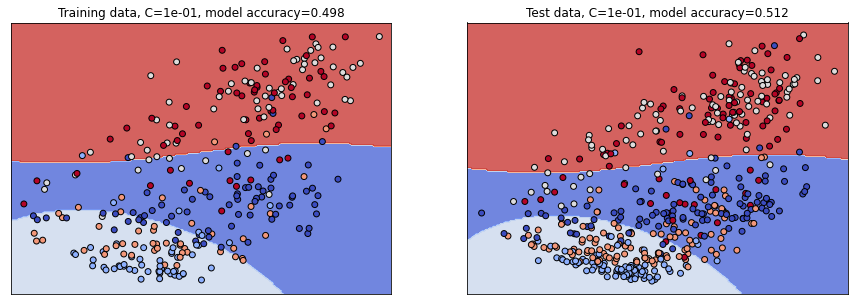

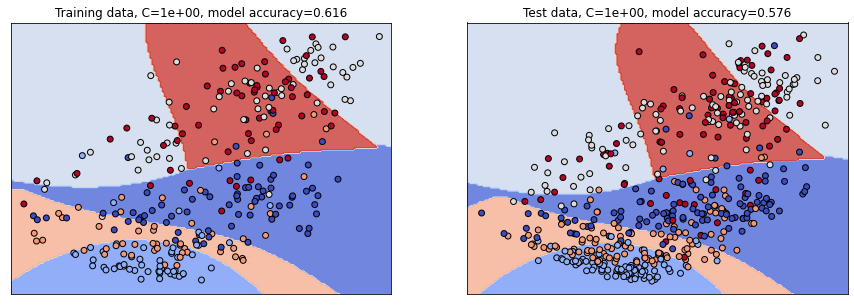

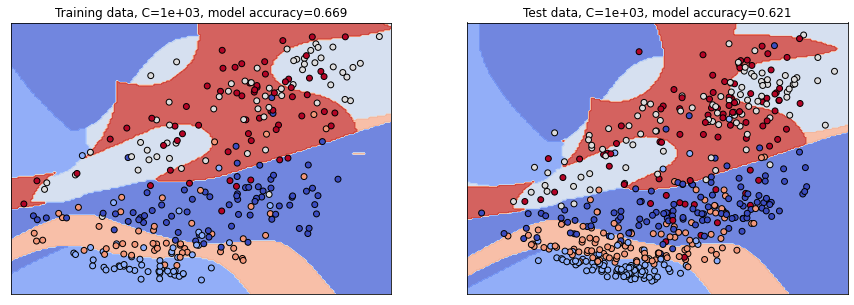

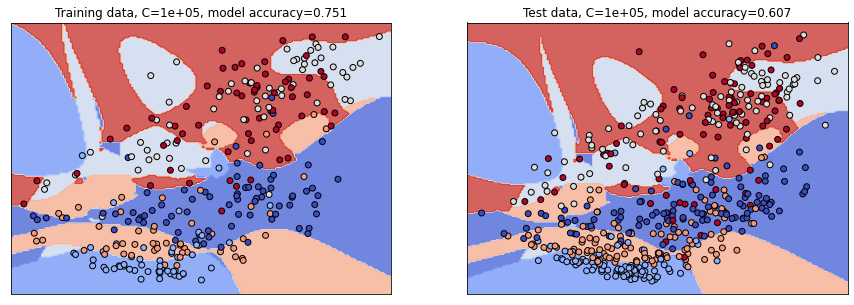

In [19]:
# Too many test samples for visualization, plot only some of them
m_test = 1000
p = np.random.permutation(X_test.shape[0])[:m_test]
X_test_red, y_test_red = X_test[p,:], y_test[p]

# Perform classification only on subset of original classes for better visualization

class_list = [0,1,2,3,4] #YOU CAN TRY TO CHANGE THE CLASSES

train_idxs = [i for i in range(len(y_train)) if y_train[i] in class_list]   
test_idxs = [i for i in range(len(y_test_red)) if y_test_red[i] in class_list] 
X_train_plot = X_train[train_idxs,:]
X_test_plot = X_test_red[test_idxs,:] 
y_train_plot = y_train[train_idxs]
y_test_plot = y_test_red[test_idxs] 


# The dimensionality is reduced to 2 for visualization using PCA
# PCA: Reduce the dimensionality trying to preserve the information content. 
# PCA will be the topic of one of the very last lectures

# Reduce X dimensionality to 2 for visualization
pca = PCA(n_components=2, svd_solver='randomized', whiten=True).fit(X_train)
X_train_pca, X_test_pca = pca.transform(X_train_plot), pca.transform(X_test_plot)


C_list = [1e-1, 1, 1e3, 1e5]
gamma = 0.5

# Fit the prediction model on train_plot data further reduced with PCA, 
# then classify with different prediction models and plot data
# Use RBF kernel 

for C in C_list:
    my_svm = SVC(kernel='rbf', C=C, gamma=gamma)
    
# scorro all'interno della lista di parametri crescenti C stampando ad ogni iterazione uno meno l'errore prodotto dall'algoritmo, ovvero la bontà dello stesso, osservando il decrescere del test error fino a vederlo crescere di nuovo a causa dell'overfitting (learning curve che si vedrà tra qualche cella)

    train_error = my_svm.fit(X_train_pca, y_train_plot).score(X_train_pca, y_train_plot)
    test_error = my_svm.fit(X_train_pca, y_train_plot).score(X_test_pca, y_test_plot)
    
    plot_data(my_svm, X_train_pca, y_train_plot, X_test_pca, y_test_plot)

## QUESTION 2
How do the shape of the boundaries changes when trying different values of C ? 
Aumentando la costante C dunque diminuendo la regolarizzazione osserviamo come i boundaries si facciano sempre più precisi nella classificazione del training set pertanto nell'allenamento. Tuttavia a causa di questo bias introdotto nel sistema ovvero nel rendere il modello complesso andiamo in contro al rischio di overfitting infatti si nota anche l'incremento del test error sintomo che il classificatore sta peggiorando nella predizione di dati nuovi, esterni al training set. 
Per C piccole allora abbiamo classificatori con grandi "margins" ma che compiono errori nel training set mentre aumentando C si restringono i "margins" rendendo l'algoritmo sempre più specifico per la classificazione del training set diminuendo conseguentemente gli errori compiuti (sempre nel training). L'overfitting si palesa nell'andamento del test error come già analizzato.

## TO DO 7

Analyze how the gamma parameter (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [20]:
#Test with different values of gamma

# Set gamma values
gamma_values = np.logspace(-5,2,10)
print(gamma_values)


[1.00000000e-05 5.99484250e-05 3.59381366e-04 2.15443469e-03
 1.29154967e-02 7.74263683e-02 4.64158883e-01 2.78255940e+00
 1.66810054e+01 1.00000000e+02]


Il miglior valore di gamma è 0.01291549665014884


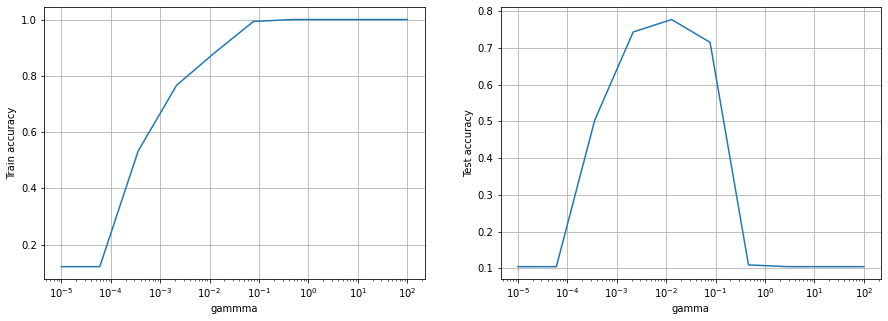

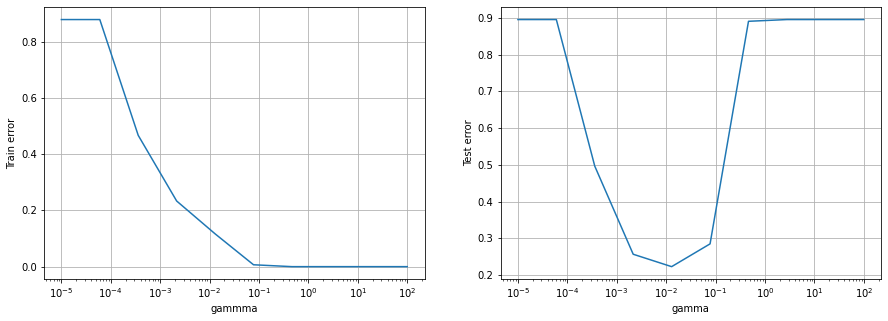

In [24]:
# Try the SVM with the previously set values of gamma
# use rbf kernel and C=1

train_acc_list, test_acc_list = [], []

for gamma in gamma_values:
    svm_gamma = SVC(kernel='rbf', C=1, gamma=gamma)
    train_acc_list.append(svm_gamma.fit(X_train, y_train).score(X_train, y_train))
    test_acc_list.append(svm_gamma.fit(X_train, y_train).score(X_test, y_test))

print('Il miglior valore di gamma è', gamma_values[np.argmin(list(map(lambda x: 1-x,test_acc_list)))])

# Plot accuracy 
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gammma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)

# Plot error 
fig, ax_error = plt.subplots(1,2, figsize=(15,5))

ax_error[0].plot(gamma_values, list(map(lambda x: 1-x,train_acc_list)))
ax_error[0].set_xscale('log')
ax_error[0].set_xlabel('gammma')
ax_error[0].set_ylabel('Train error')
ax_error[0].grid(True)

ax_error[1].plot(gamma_values, list(map(lambda x: 1-x,test_acc_list)))
ax_error[1].set_xscale('log')
ax_error[1].set_xlabel('gamma')
ax_error[1].set_ylabel('Test error')
ax_error[1].grid(True)

plt.show()

## QUESTION 3
How do the train and test error change when changing gamma ? Which is the best value of gamma ? 
Connect your answers to the discussion about the overfitting issue. 

Dal grafico di cui sopra si osserva che:
-il training error tende a diminuire all'aumentare del parametro gamma fino ad un valore di saturazione, in questo caso zero;

-il test error diminuisce insieme al training error al crescere di gamma ma, a differenza del primo, raggiunge un minimo per poi aumentare nuovamente tornando a come era in partenza.

Gamma (1/sigma) rappresenta il concetto di "vicinanza" nella funzione kernel gaussiana infatti diminuendo gamma si costruisce una soluzione più generale, ma non per forza ottimale sul training error.
Aumentando gamma, invece, diminuisce la deviazione standard del kernel e si restringono anche i decision boundaries in cui il classificatore predice un sample correttamente adattandosi sempre di più alla distribuzione di punti del training set. Il modello si specializza nella classificazione del training set riducendosi ad overfitting. Quanto visto corrisponde a ciò che dovrebbe accadere in teoria.
Quando gamma è elevato, sigma piccolo, i boundaries seguono la distribuzione del training set ottenendo un training error molto basso ma restituendo un modello poco generale, test error elevato.
Quando gamma è piccolo (ma non troppo), sigma grande, i boundaries si allontanano dalla distribuzione del training set rendendo la classificazione più generale e raggiungendo un test error minore del caso precedente. Attenzione che se si riduce troppo gamma allora l'algoritmo inizia a sbagliare sia sul training set che sul test in quanto si diminuisce la capacità di apprendimento dello stesso. Bisogna dunque individuare il giusto compromesso tra test e training error e lo si fa guardando al gamma che rende minimo il test error, dalla curva test error vs gamma si scorge a occhio il valore $\gamma=10^{-2}$.

## More data
Now let's do the same but using more data points for training.


Choose a new number of data points.

In [48]:
X = X[permutation]
y = y[permutation]

m_training_md = 3000 # number of data points, adjust depending on the capabilities of your PC

X_train_md, X_test_md = X[:m_training_md], X[m_training_md:]
y_train_md, y_test_md = y[:m_training_md], y[m_training_md:]

labels, freqs = np.unique(y_train, return_counts=True)
print("Labels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [73 55 64 51 62 47 71 65 56 56]


## TO DO 8

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  1500$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the cell below.

In [49]:
#get training and test error for the best SVM model from CV
# utilizzo SVM con i parametri ottenuti dal miglior classificatore tramite la funzione bestsvm
training_error_md = 1-best_SVM.fit(X_train_md, y_train_md).score(X_train_md, y_train_md)
test_error_md = 1-best_SVM.fit(X_train_md, y_train_md).score(X_test_md, y_test_md)
print ("Best SVM training error: %f" % training_error_md)
print ("Best SVM test error: %f" % test_error_md)

Best SVM training error: 0.069667
Best SVM test error: 0.146982


Just for comparison, let's also use logistic regression 

## TO DO 9 Try first without regularization (use a very large large C)¶

In [50]:
# definisco una funzione che mi conti il numero di samples misclassified durante la logistic regression
def error_lr(m,y_real,y_predict) :
    misclass = 0
    for i in range(m) :
        if y_predict[i] != y_real[i] :
            misclass += 1
    return misclass/m

In [51]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5) 
logreg.fit(X_train, y_train) # in questo modo alleno l'algoritmo sui dati nel training set
y_predict_train = logreg.predict(X_train)
y_predict_test = logreg.predict(X_test)
training_error_lr = error_lr(m_training,y_train,y_predict_train)
test_error_lr = error_lr(m_test,y_test,y_predict_test)

print ("Best logistic regression training error: %f" % training_error_lr)
print ("Best logistic regression training error: %f" % (1-logreg.score(X_train, y_train)))
print ("Best logistic regression test error: %f" % test_error_lr)
print('Best logistic regression test error with .score: %f' % (1-logreg.score(X_test, y_test)))

Best logistic regression training error: 0.000000
Best logistic regression training error: 0.000000
Best logistic regression test error: 0.230000
Best logistic regression test error with .score: 0.231500


## TO DO 10 Try  with regularization (use C=1)¶

In [52]:
logreg1 = linear_model.LogisticRegression(C=1) 
logreg1.fit(X_train, y_train) 
y_predict_train1 = logreg.predict(X_train)
y_predict_test1 = logreg.predict(X_test)
training_error_lr1 = error_lr(m_training,y_train,y_predict_train1)
test_error_lr1 = error_lr(m_test,y_test,y_predict_test1)

print ("Best regularized logistic regression training error: %f" % training_error_lr1)
print ("Best regularized logistic regression training error with .score: %f" % (1-logreg1.score(X_train, y_train)))
print ("Best regularized logistic regression test error: %f" % test_error_lr1)
print('Best logistic regression test error with .score: %f' % (1-logreg1.score(X_test, y_test)))

Best regularized logistic regression training error: 0.000000
Best regularized logistic regression training error with .score: 0.000000
Best regularized logistic regression test error: 0.230000
Best logistic regression test error with .score: 0.215500


In [53]:
# per vedere di quanto differiscono i parametri nelle due logistic regressions 
print('Differenza tra i parametri delle due LR\n', np.abs(np.abs(logreg1.intercept_)-np.abs(logreg.intercept_)),'\n', np.abs(np.abs(logreg1.coef_)-np.abs(logreg.coef_)))

Differenza tra i parametri delle due LR
 [0.10630681 0.29984758 0.79266157 1.45277385 3.92924439 7.18635106
 1.75262953 0.77189798 2.02901923 3.20550378] 
 [[1.14877022e-02 1.13674021e-02 1.20016865e-02 ... 6.67112567e-01
  2.37626301e-02 8.23508084e-03]
 [2.69479546e-04 2.71595817e-04 3.95718531e-04 ... 2.58980517e-02
  1.98487128e-02 1.79440268e-04]
 [2.29456039e-03 2.24741839e-03 1.41703870e-02 ... 6.28920130e-01
  1.64373091e-01 1.31940604e-03]
 ...
 [1.47056193e-04 1.47717619e-04 2.57406528e-04 ... 6.35997847e-02
  1.23344597e-01 9.18524872e-05]
 [2.07284658e-03 2.13178481e-03 3.50400096e-03 ... 9.42466747e-02
  1.26438875e-01 1.32023919e-04]
 [1.65467139e-04 1.70599397e-04 2.96093303e-04 ... 9.48256500e-02
  1.68738655e-01 9.87105873e-05]]


In [54]:
# Le labels predette dalle due LR con diverse regularizations sono identiche. Calcolando l'errore semplicemente verificando quanti elementi sono stati classificati male rispetto al totale trovo 0.23 in entrambi i casi mentre utilizzando il metodo .score built in nella funzione LogisticRegression ottengo 0.2315 e 0.2155
if np.allclose(y_predict_test, y_predict_test1):
    print("I due test errors differiscono perchè .score() e error_lr() calcolano l'errore in maniera differente")

I due test errors differiscono perchè .score() e error_lr() calcolano l'errore in maniera differente


## QUESTION 4
Compare and discuss:
- the results from SVM with m=600 and with m=1500 training data points. If you stopped the SVM, include such aspect in your comparison.
- the results of SVM and of Logistic Regression <br>
<br>
Ricapitoliamo i risultati finora ottenuti: 
- con m=600 si trovano training error$\approx$0.06 e test error$\approx$0.201250 
- con m=1500 si trovano training error$\approx$0.063333 e test error$\approx$0.167880
- tramite la logistic regression, per entrambi i valori del parametro C si osserva un training error = 0 e un test error$\approx$0.23
Aumentando il numero di samples di allenamento nell'algoritmo SVM si fa in modo di rendere il training set più rappresentativo della realtà, si complica il modello dunque il training error aumenta, sebbene di poco, con il vantaggio però di un test error minore del 10%.
La logistic regression invece restituisce un training error pari a zero e un test maggiore di entrambi i casi analizzati sopra. Ciò significa che è probabile un overfitting dell'algoritmo. Tramite un conteggio diverso dell'errore si osserva come, nonostante il training error rimanga nullo, il test migliora diminuendo il valore di C (aumentando lambda) parametro di regolarizzazione che rende meno 

## TO DO 11
Plot an item of clothing that is missclassified by logistic regression and correctly classified by SVM.

INPUT:


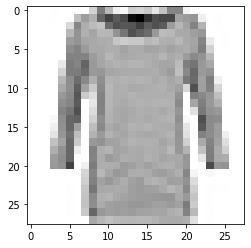

LABEL: 0
LABEL misclassified by LR:  2


In [55]:
LR_prediction = logreg.predict(X_test) 
SVM_prediction = best_SVM.predict(X_test)
# utilizzo la funzione plotinput per rappresentare il primo indumento in ordine di apparizione tra i test samples che sia stato predetto dal SVM e non sia stato classificato correttamente dalla logistic regression. Devo confrontare con y_test
for i in range(len(LR_prediction)):
    if LR_prediction[i] != SVM_prediction[i] and SVM_prediction[i] == y_test[i] :
        plot_input(X_test,y_test,i)
        print('LABEL misclassified by LR: ',LR_prediction[i])
        break

## TO DO 12
Plot the confusion matrix for the SVM classifier and for logistic regression.
The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label.
Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors.
You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation).
Try also to normalize the confusion matrix by the number of samples in each class in order to measure the accuracy on each single class.


Labels and frequencies in test set:  [418 397 402 383 400 405 393 386 380 436]


Text(100.90909090909095, 0.5, 'predicted label')

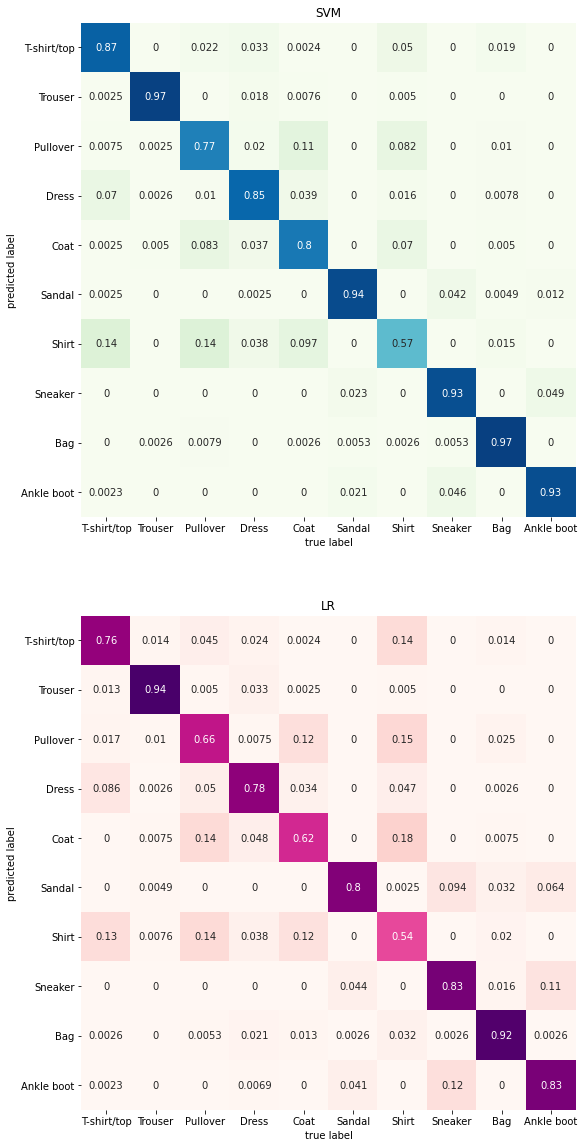

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
np.set_printoptions(precision=2, suppress=True) # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts=True)
print("Labels and frequencies in test set: ", counts)
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
confusion_SVM = confusion_matrix(y_test, best_SVM.predict(X_test))/counts[:,None]
confusion_LR = confusion_matrix(y_test, logreg.predict(X_test))/counts[:,None]

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,20))
ax1 = sns.heatmap(confusion_SVM, square=True, annot=True, cbar=False, cmap='GnBu', xticklabels=labels, yticklabels=labels, ax=ax1)
ax1.set_title('SVM')
ax1.set_xlabel('true label')
ax1.set_ylabel('predicted label')

ax2 = sns.heatmap(confusion_LR, square=True, annot=True, cbar=False, cmap='RdPu', xticklabels=labels, yticklabels=labels, ax=ax2)
ax2.set_title('LR')
ax2.set_xlabel('true label')
ax2.set_ylabel('predicted label')

In [57]:
# per avere un'occhiata più veloce sulla matrice di confusione 
print("\n Confusion matrix SVM (normalized)\n \n", confusion_SVM)
print("\n Confusion matrix LR (normalized)\n \n", confusion_LR) 


 Confusion matrix SVM (normalized)
 
 [[0.87 0.   0.02 0.03 0.   0.   0.05 0.   0.02 0.  ]
 [0.   0.97 0.   0.02 0.01 0.   0.01 0.   0.   0.  ]
 [0.01 0.   0.77 0.02 0.11 0.   0.08 0.   0.01 0.  ]
 [0.07 0.   0.01 0.85 0.04 0.   0.02 0.   0.01 0.  ]
 [0.   0.01 0.08 0.04 0.8  0.   0.07 0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.94 0.   0.04 0.   0.01]
 [0.14 0.   0.14 0.04 0.1  0.   0.57 0.   0.02 0.  ]
 [0.   0.   0.   0.   0.   0.02 0.   0.93 0.   0.05]
 [0.   0.   0.01 0.   0.   0.01 0.   0.01 0.97 0.  ]
 [0.   0.   0.   0.   0.   0.02 0.   0.05 0.   0.93]]

 Confusion matrix LR (normalized)
 
 [[0.76 0.01 0.05 0.02 0.   0.   0.14 0.   0.01 0.  ]
 [0.01 0.94 0.01 0.03 0.   0.   0.01 0.   0.   0.  ]
 [0.02 0.01 0.66 0.01 0.12 0.   0.15 0.   0.02 0.  ]
 [0.09 0.   0.05 0.78 0.03 0.   0.05 0.   0.   0.  ]
 [0.   0.01 0.14 0.05 0.62 0.   0.18 0.   0.01 0.  ]
 [0.   0.   0.   0.   0.   0.8  0.   0.09 0.03 0.06]
 [0.13 0.01 0.14 0.04 0.12 0.   0.54 0.   0.02 0.  ]
 [0.   0.   0.   0.  

## QUESTION 5
Have a look at the confusion matrices and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one ? Make some guesses on the possible causes. 
Si osserva come previsto che la diagonale principale delle matrici di confusione possiede le componenti maggiori rispetto alle altre righe e colonne. Ciò indica che l'algoritmo per lo più è stato in grado di classificare correttamente i samples (vestiti) analizzati nel test set e dunque le etichette vere e predette corrispondono. 
Tuttavia osserviamo alcune classi che hanno una precisione minore ovvero un maggior numero di predizioni errate. Si vede ad esempio che le tshirt siano state classificate come shirts e dresses più frequentemente rispetto alle altre tipologie di capi (naturalmente meno rispetto alla classificazione corretta in tshirts). Lo stesso accade per i pullover classificati come coats o shirts, per i coats simmetricamente classificati come shirts e pullover,per le shirts viste come coats, pullover e tshirts/tops, infine per le sneakers come ankle boots e sandal e analogamente per ankle boots e sandal permutando queste tre etichette tra loro. Si nota un pattern ricorrente di errata predizione della tipologia di indumento: l'algoritmo si "confonde" quando incappa in vestiti simili nel genere a quelli che sta classificando. Ad esempio la categoria di quelli che si usano per il busto, quelli per le gambe e le scarpe. Un controesempio accade per le bags che essendo uniche in quest elenco come accessorio, hanno meno misclassified samples. 